## Simple Neural Network

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

To generate the coffee roasting dataset

In [3]:
def load_coffee_data():
    """
    Creates a coffee roasting dataset.
    roasting duration: 12-15 minutes is best
    temperature range: 175-260C is best
    """

    rng = np.random.default_rng(2)  # random number generator with seed 2

    X = rng.random(400).reshape(-1, 2)  # generates numbers b/w 0 and 1. shaped as 200 rows and 2 columns
    X[:, 1] = X[:, 1] * 4 + 11.5  # creates values for the duration column
    X[:, 0] = X[:, 0] * (285-150) + 150  # temperature column
    Y = np.zeros(len(X))  # Y array of length 200 initialized to 0

    i = 0
    for t, d in X:
        y = -3/(260-175)*t + 21  # for each temperature 't' it calculates a threshold duration 'y'
        if (t > 175 and t < 260 and d > 12 and d < 15 and d <= y):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1, 1))

In [4]:
X, Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


It is suggested that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink.

### Model

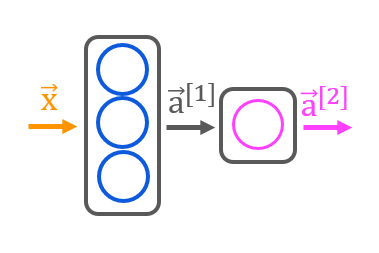

In [23]:
torch.manual_seed(42)

class CoffeeRoastingNetwork(nn.Module):
    def __init__(self):
        super(CoffeeRoastingNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 3)  # 2 input features, 3 hidden neurons
        self.layer2 = nn.Linear(3, 1)  # 3 hidden neurons, 1 output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

In [24]:
# number of trainable paramters in the model
L1_num_params = 2 * 3 + 3  # W1 + b1
L2_num_params = 3 * 1 + 1  # W2 + b2
print(f"Layer 1 parameters = {L1_num_params}, Layer 2 parameters = {L2_num_params}")

Layer 1 parameters = 9, Layer 2 parameters = 4


- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [62]:
# converting to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

model = CoffeeRoastingNetwork()

for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

layer1.weight: tensor([[-0.1997, -0.4252],
        [ 0.0667, -0.6984],
        [ 0.6386, -0.6007]])
layer1.bias: tensor([ 0.5459,  0.1177, -0.2296])
layer2.weight: tensor([[0.3568, 0.0900, 0.4665]])
layer2.bias: tensor([0.0631])


#### Let's Normalize the data first

In [63]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:, 0]):0.2f}, {np.min(X[:, 0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:, 1]):0.2f}, {np.min(X[:, 1]):0.2f}")

# Manual normalization
mean = X_tensor.mean(dim=0, keepdim=True)
std = X_tensor.std(dim=0, keepdim=True)
X_normalized = (X_tensor - mean) / std

Xn_np = X_normalized.detach().numpy()  # converting to np for printing

print(f"Temperature Max, Min post normalization: {np.max(Xn_np[:, 0]):0.2f}, {np.min(Xn_np[:, 0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn_np[:, 1]):0.2f}, {np.min(Xn_np[:, 1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.68
Duration    Max, Min post normalization: 1.79, -1.70


In [64]:
# loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [67]:
# training the model

epochs = 10000
for epoch in range(epochs):
    # forward pass
    outputs = model(X_normalized)
    loss = criterion(outputs, Y_tensor)

    # backward pass
    optimizer.zero_grad()  # set gradients to 0
    loss.backward()  # calculate gradients using backprop
    optimizer.step()  # update weights

    if epoch % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}") 

Epoch [1/10000], Loss: 0.1408
Epoch [1001/10000], Loss: 0.1267
Epoch [2001/10000], Loss: 0.1129
Epoch [3001/10000], Loss: 0.0286
Epoch [4001/10000], Loss: 0.0163
Epoch [5001/10000], Loss: 0.0112
Epoch [6001/10000], Loss: 0.0077
Epoch [7001/10000], Loss: 0.0049
Epoch [8001/10000], Loss: 0.0028
Epoch [9001/10000], Loss: 0.0016


In [68]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

layer1.weight: tensor([[-39.3428,   0.5090],
        [ -0.4671, -23.5671],
        [-60.8974, -49.3944]])
layer1.bias: tensor([-42.5607, -29.5947,  -6.2594])
layer2.weight: tensor([[-29.7147, -27.6083,  30.7390]])
layer2.bias: tensor([-14.6046])


### Predicting
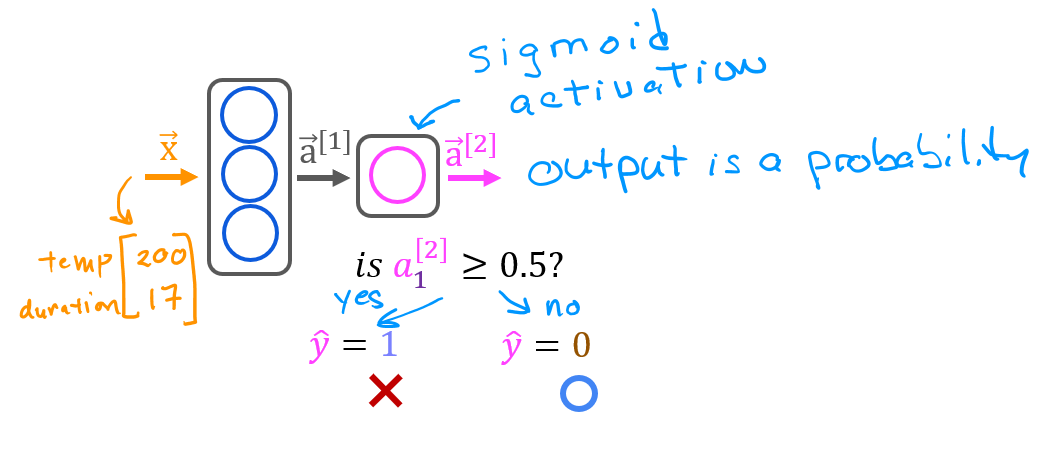

In [73]:
# let's test the model on some test data
X_test = torch.tensor([[200, 13.9],  # positive example
                       [200, 17]])  # negative example

# we need to normalize our inputs before using the model
X_test_normalized = (X_test - mean) / std

In [77]:
with torch.no_grad():
    predictions = model(X_test_normalized)
    print(f"Predictions = \n {predictions.data}")

    # to convert probabilities into a decision (1 or 0, yes or no, etc)
    decisions = (predictions > 0.5).float()
    print(f"decisions:\n{decisions}")

Predictions = 
 tensor([[9.9998e-01],
        [4.5426e-07]])
decisions:
tensor([[1.],
        [0.]])


### Layer Functions

Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.

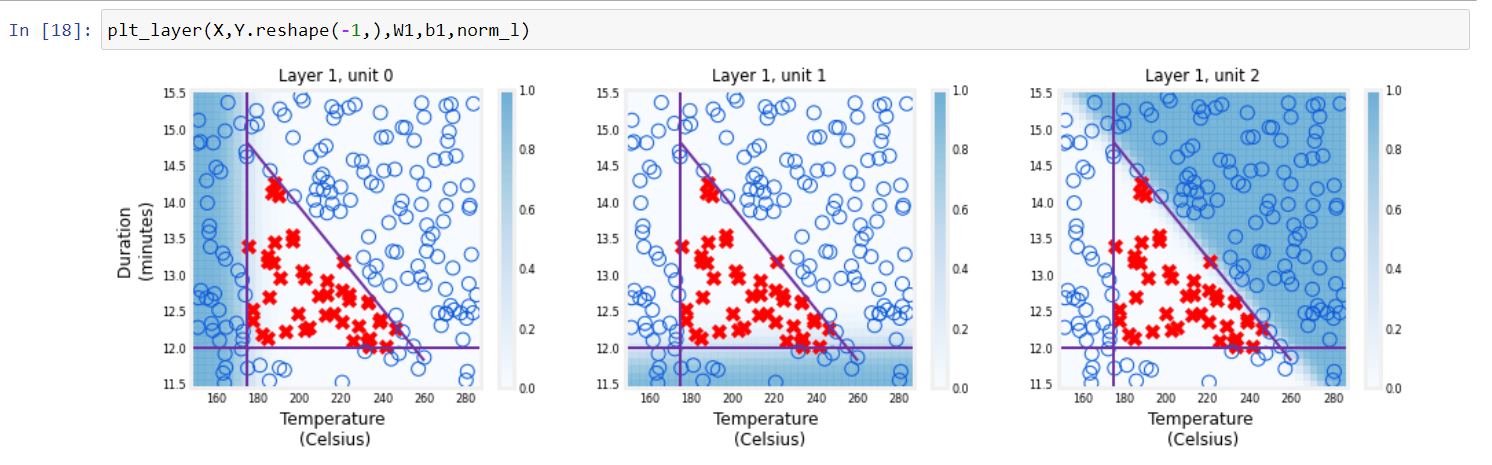

The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.

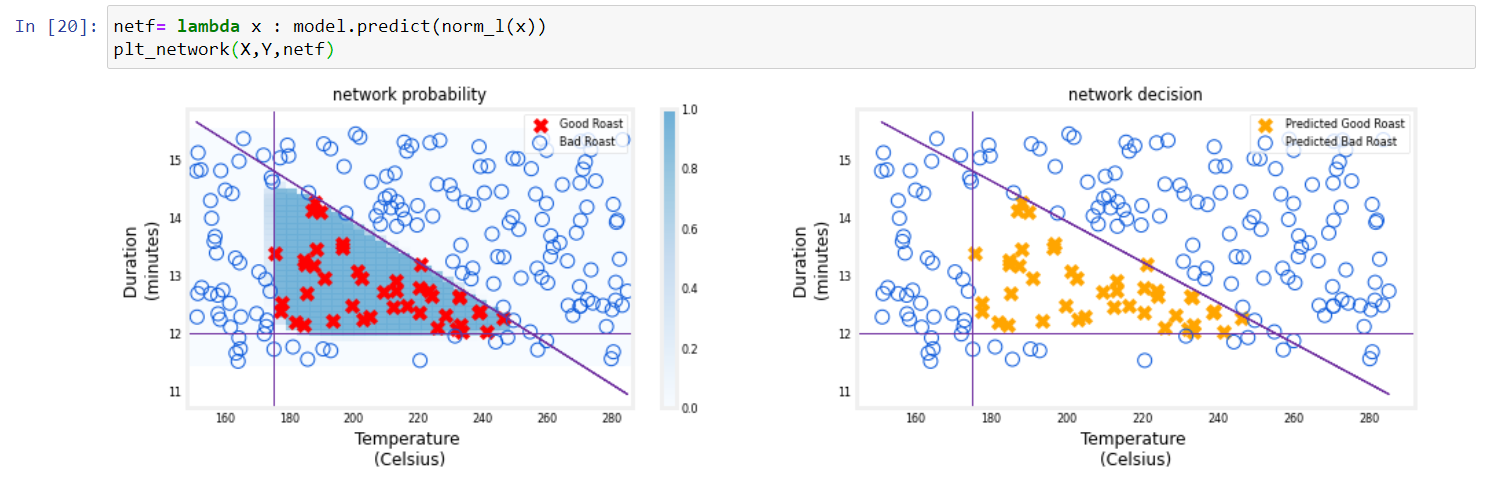